# Что такое тренд? #

Компонента **тренда** временного ряда представляет устойчивое, долгосрочное изменение среднего значения ряда. Тренд — самая медленно меняющаяся часть ряда, часть, отражающая самый крупный по времени масштаб. В ряду продаж продукта растущий тренд может быть следствием расширения рынка, когда всё больше людей узнают о продукте из года в год.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/ZdS4ZoJ.png" width=800, alt="">
<figcaption style="textalign: center; font-style: italic"><center>Трендовые паттерны в четырёх временных рядах.</center></figcaption>
</figure>

В этом курсе мы сосредоточимся на трендах в среднем. В более общем смысле любое устойчивое и медленное изменение в ряду может считаться трендом — например, у временных рядов часто есть тренды в вариативности.

# Графики скользящего среднего #

Чтобы понять, какой тренд может быть у временного ряда, мы можем использовать **график скользящего среднего**. Чтобы вычислить скользящее среднее ряда, мы считаем среднее значений внутри скользящего окна заданной ширины. Каждая точка на графике представляет среднее всех значений ряда, попавших в окно по обе стороны. Идея — сгладить краткосрочные колебания, чтобы остались только долгосрочные изменения.

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/EZOXiPs.gif" width=800, alt="Анимированный график: волнообразная кривая постепенно растёт, а линия скользящего среднего формируется слева направо в окне из 12 точек (красные).">
<figcaption style="textalign: center; font-style: italic"><center>График скользящего среднего, иллюстрирующий линейный тренд. Каждая точка на кривой (синяя) — это среднее точек (красных) в окне размера 12.
</center></figcaption>
</figure>

Обратите внимание, что ряд *Mauna Loa* выше имеет повторяющееся движение вверх и вниз из года в год — краткосрочное, *сезонное* изменение. Чтобы изменение было частью тренда, оно должно происходить на более длительном промежутке, чем любые сезонные изменения. Поэтому для визуализации тренда мы берём среднее за период длиннее любого сезонного периода в ряду. Для ряда *Mauna Loa* мы выбрали окно размера 12, чтобы сгладить сезонность внутри каждого года.


# Инженерия тренда #

После того как мы определили форму тренда, можно попытаться смоделировать его с помощью признака времени. Мы уже видели, что использование самого временного фиктивного признака моделирует линейный тренд:

```
target = a * time + b
```

Мы можем подогнать и многие другие типы тренда через преобразования временного признака. Если тренд выглядит квадратичным (парабола), достаточно добавить квадрат временного признака в набор признаков, получив:
```
target = a * time ** 2 + b * time + c
```
Линейная регрессия выучит коэффициенты `a`, `b` и `c`.

Трендовые кривые на рисунке ниже были получены с помощью таких признаков и `LinearRegression` из scikit-learn:

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/KFYlgGm.png" width=*00, alt="Сверху: Cars Sold in Quebec — волнообразный график, постепенно растущий с 1960-01 по 1968-12, с наложенной линейной линией тренда. Снизу: Plastics Production in Australia — волнообразный график с наложенной квадратичной (выпуклой вверх) линией тренда.">
<figcaption style="textalign: center; font-style: italic"><center><strong>Сверху:</strong> Ряд с линейным трендом. <strong>Снизу:</strong> Ряд с квадратичным трендом.
</center></figcaption>
</figure>

Если вы не видели этот приём раньше, возможно, вы не знали, что линейная регрессия может аппроксимировать кривые, а не только прямые. Идея в том, что если вы можете предоставить признаки в форме подходящих кривых, то линейная регрессия научится комбинировать их так, чтобы наилучшим образом подогнать целевую переменную.

# Пример — Tunnel Traffic #

В этом примере мы создадим модель тренда для набора данных *Tunnel Traffic*.


In [2]:

from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("../dataset/")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

Сделаем график скользящего среднего, чтобы увидеть, какой тренд есть у этого ряда. Поскольку наблюдения здесь ежедневные, возьмём окно 365 дней, чтобы сгладить любые краткосрочные изменения внутри года.

Чтобы создать скользящее среднее, сначала используйте метод `rolling`, чтобы начать вычисления в окне. Затем примените метод `mean`, чтобы посчитать среднее по окну. Как мы видим, тренд у *Tunnel Traffic* выглядит примерно линейным.


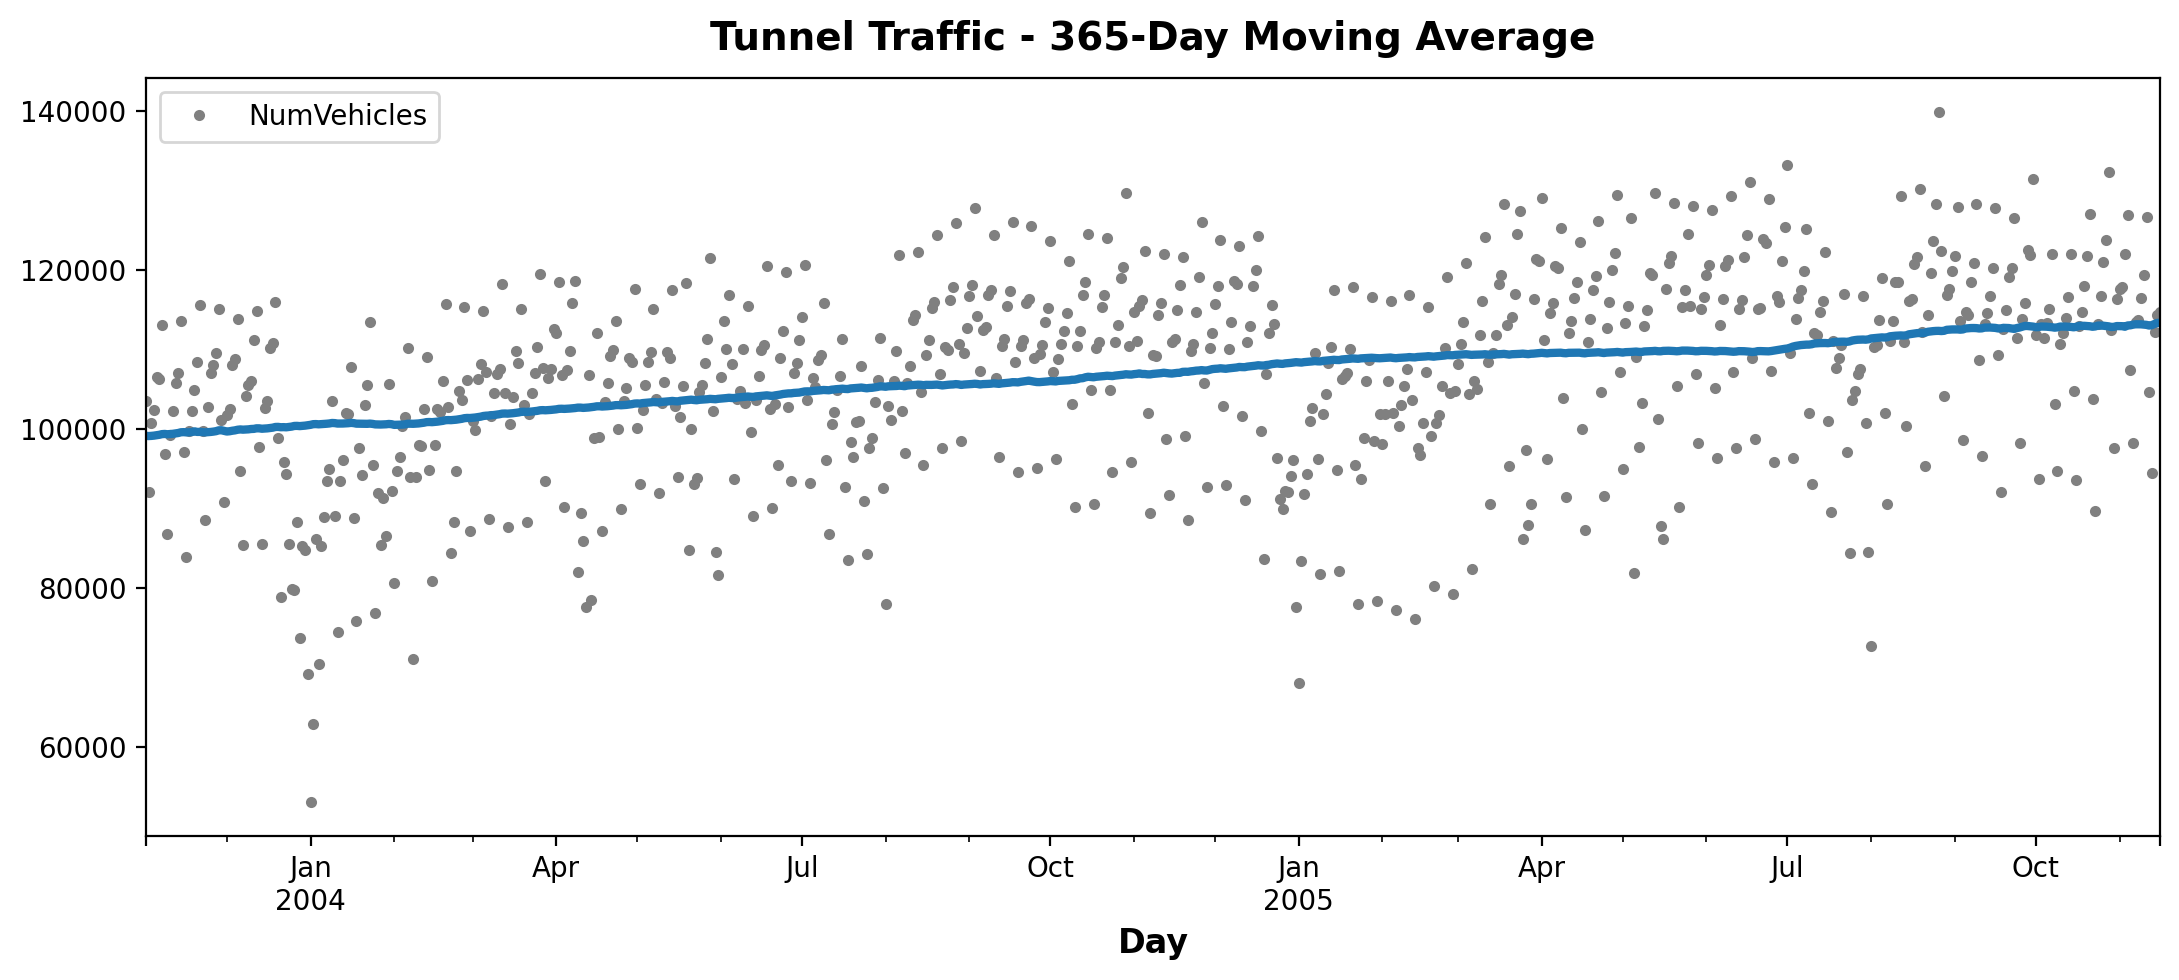

In [3]:
moving_average = tunnel.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Tunnel Traffic - 365-Day Moving Average", legend=False,
);

В Уроке 1 мы создавали временной признак в Pandas напрямую. С этого момента мы будем использовать функцию из библиотеки `statsmodels`, которая называется `DeterministicProcess`. Эта функция помогает избежать некоторых сложных ошибок, которые могут возникать при работе с временными рядами и линейной регрессией. Аргумент `order` задаёт порядок полинома: `1` — линейный, `2` — квадратичный, `3` — кубический и так далее.


In [4]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Day,,
2003-11-01,1.0,1.0
2003-11-02,1.0,2.0
2003-11-03,1.0,3.0
2003-11-04,1.0,4.0
2003-11-05,1.0,5.0


(Кстати, *детерминированный процесс* — это технический термин для временного ряда, который неслучаен или полностью *определён*, как серии `const` и `trend`. Признаки, полученные из временного индекса, обычно являются детерминированными.)

Мы создаём модель тренда почти так же, как раньше, но обратите внимание на добавление аргумента `fit_intercept=False`.


In [5]:
from sklearn.linear_model import LinearRegression

y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

Тренд, найденный нашей моделью `LinearRegression`, почти идентичен графику скользящего среднего, что говорит о том, что линейный тренд был правильным выбором в этом случае.


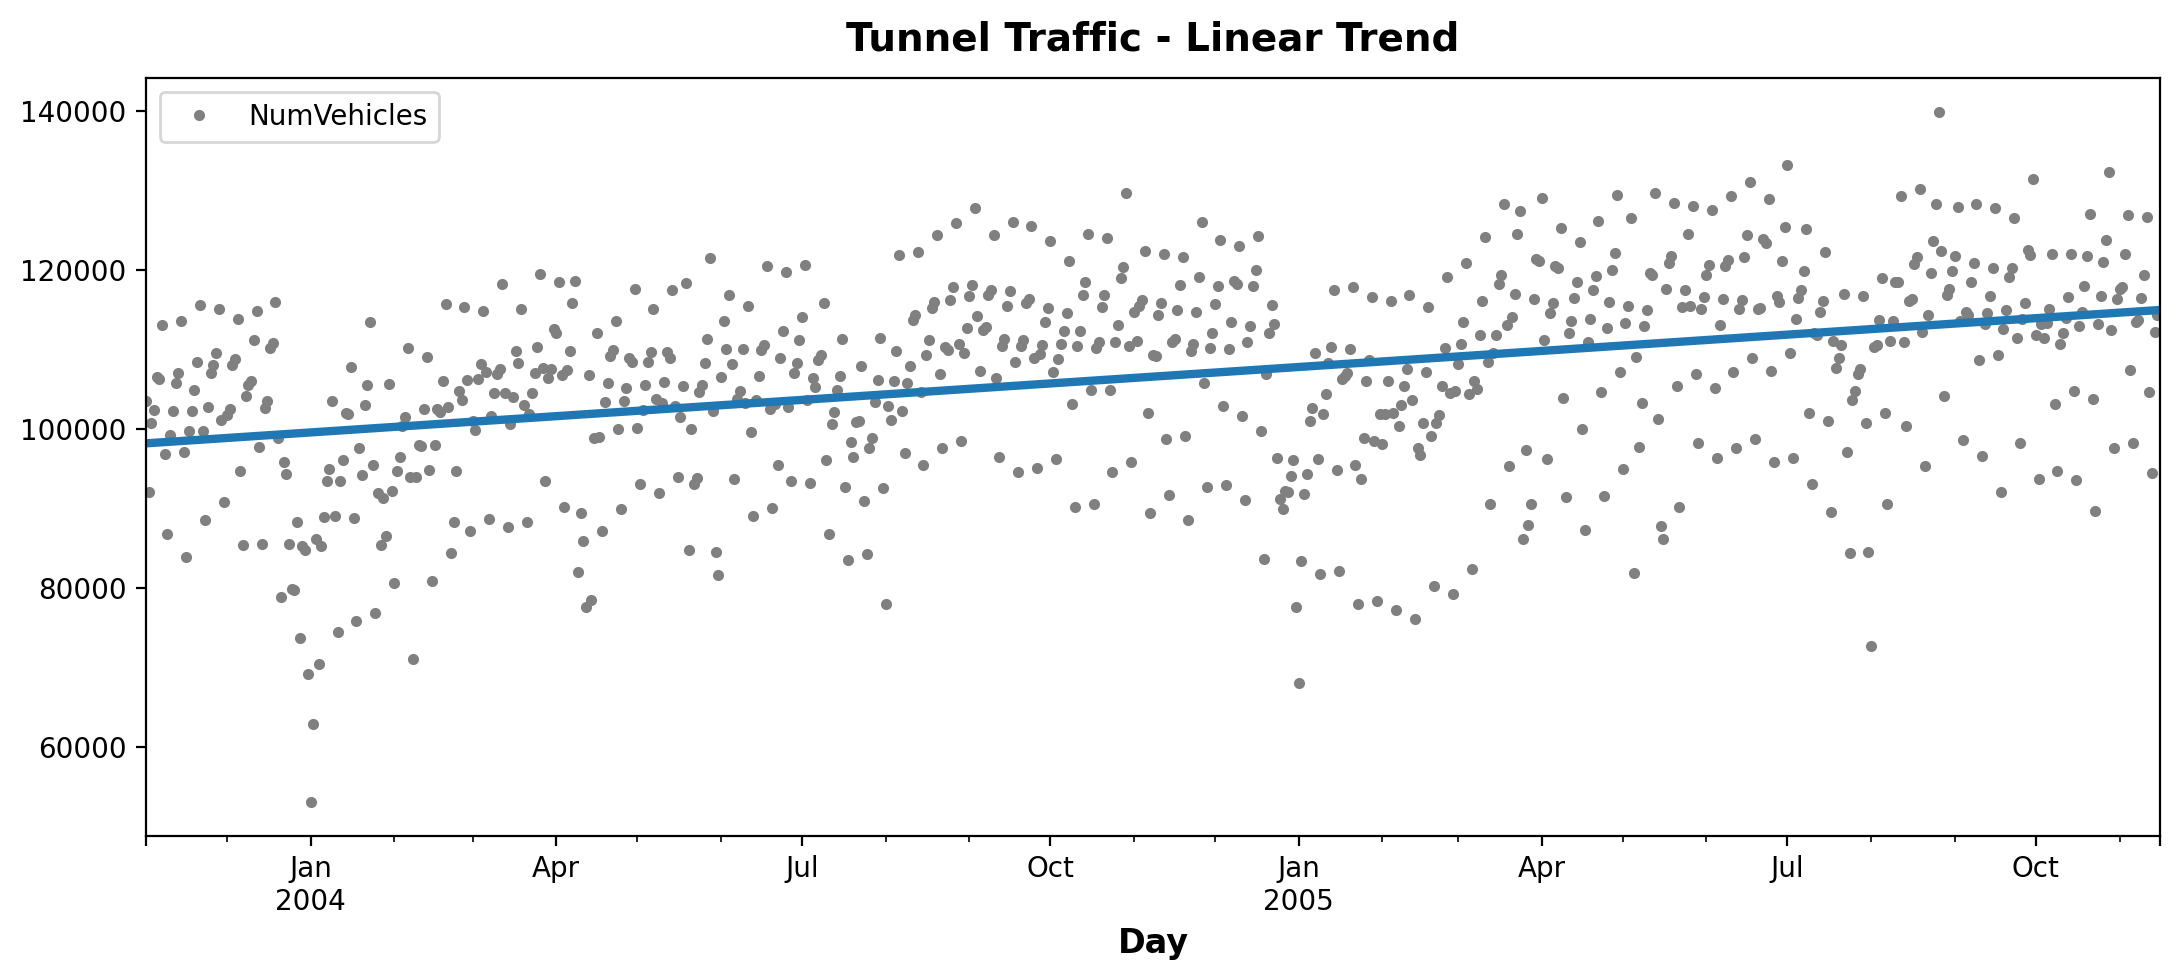

In [6]:

ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

Чтобы сделать прогноз, мы применяем модель к признакам «вне выборки». «Вне выборки» означает моменты времени за пределами периода наблюдений обучающих данных. Вот как можно сделать 30‑дневный прогноз:


In [7]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Давайте построим часть ряда, чтобы увидеть прогноз тренда на следующие 30 дней:


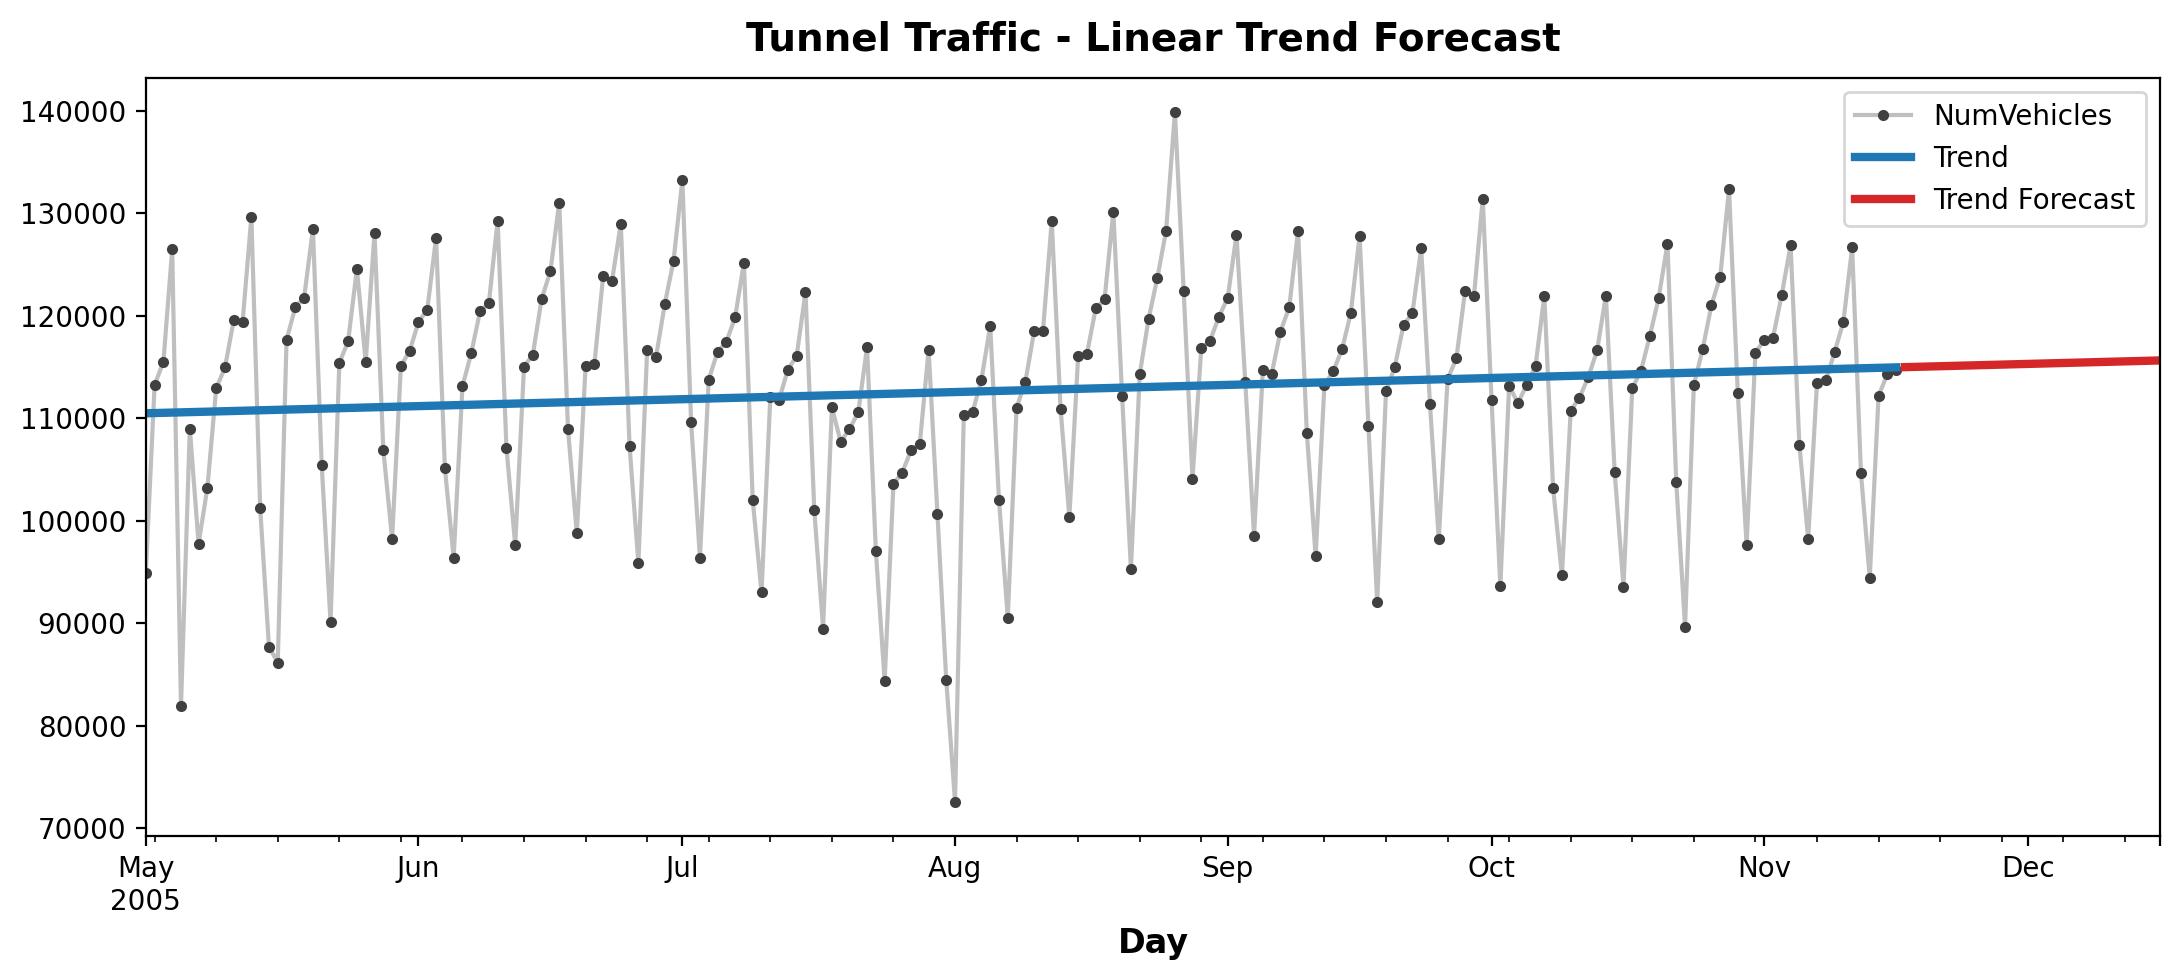

In [8]:

ax = tunnel["2005-05":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params)
ax = y_pred["2005-05":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

---

Модели тренда, с которыми мы познакомились в этом уроке, оказываются полезными по многим причинам. Помимо роли базовой линии или отправной точки для более сложных моделей, мы можем использовать их как компонент в «гибридной модели» с алгоритмами, не умеющими учить тренды (например, XGBoost и случайные леса). Подробнее об этой технике мы узнаем в Уроке 5.

# Ваша очередь #

[**Смоделируйте тренд в Store Sales**](https://www.kaggle.com/kernels/fork/19616015) и разберитесь с рисками прогнозирования с полиномами высокого порядка.


---




*Есть вопросы или комментарии? Посетите [форум обсуждений курса](https://www.kaggle.com/learn/time-series/discussion), чтобы пообщаться с другими учащимися.*
